In [1]:
####  initialization
from __future__ import print_function
from __future__ import division
%reset
import time
import os
import sys
sys.path.append('.')
sys.path.append('..')
import copy

print(sys.version)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

print(torch.__version__)
import numpy as np

import dnnlib
import legacy
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from PIL import Image

import pickle
import math
# torch.cuda.set_device(1)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'




device = torch.device('cuda:0')
print('CUDA is available: ',torch.cuda.is_available())
mpth = '../weights/network-snapshot-005400.pkl'
with dnnlib.util.open_url(mpth) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

with dnnlib.util.open_url(mpth) as f:
    g_style = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore
       

3.9.22 | packaged by conda-forge | (main, Apr 14 2025, 23:35:59) 
[GCC 13.3.0]


/home/zack/miniforge3/envs/retina39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.11.0+cu113
CUDA is available:  True


Setting up PyTorch plugin "filtered_lrelu_plugin"... 

/home/zack/miniforge3/envs/retina39/lib/python3.9/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Done.


/home/zack/miniforge3/envs/retina39/lib/python3.9/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


<class 'tuple'> 1 <class 'torch.Tensor'> torch.Size([1, 128]) torch.Size([128])
total_output_size: 1.0 16
n_total_output_size: 1.0 16
num_affine_layers 16
6179 3
16 torch.Size([128])
71
current edit layer and channels are:  5 [236.]


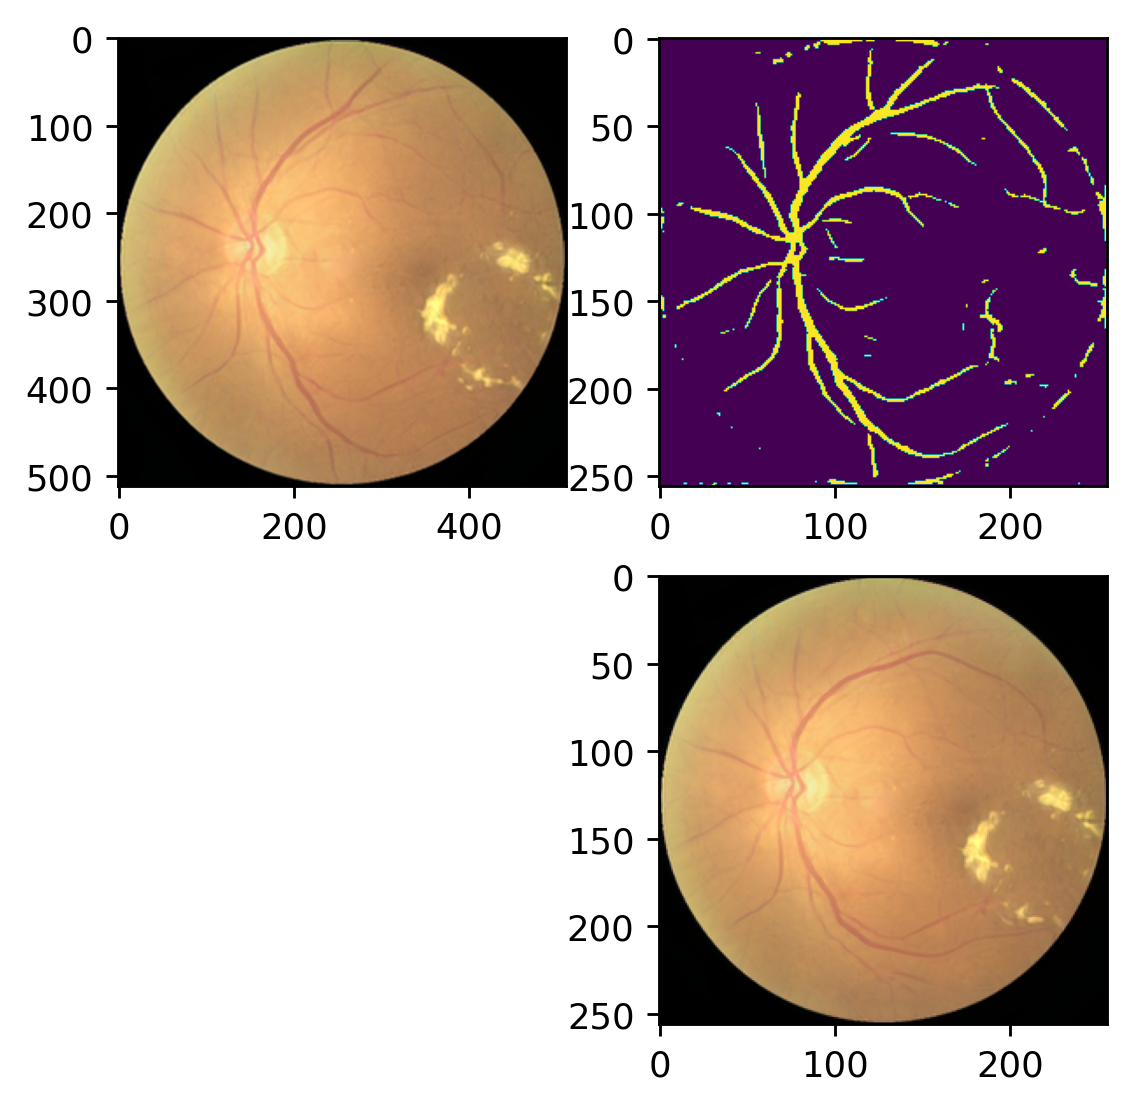

In [2]:

debug_image = True
calculate_grad = False
calculate_corres = True
use_backward_grad = True

# load_grad = False # if need load, then True, if have loaded, then False
load_corre = False

use_vessel_mask = True
generate_from_w = True

filename = 'test4043'
img_w_latent = filename
z_filename = '../latents/{}/projected_w.npy'.format(img_w_latent)

# grad_filename = 'tmp/gradnpy/grad/grads_{}'.format(filename)
# corre_filename = 'tmp/gradnpy/grad/corres_{}'.format(filename)
plt.figure(figsize=(5,5),dpi=256)


########################################################################################
############################  vessel segment  ##########################################
########################################################################################

sys.path.append('../ThirdPart/')
from unetseg.model import build_unet as unetseg
def vessel_seg(image):
 
    def LoadModel(model_path,device=device):
        net = unetseg().to(device)
        net.load_state_dict(torch.load(model_path,map_location=device))
        net.eval()

        to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        return net,to_tensor

    unet_model_pth = '../weights/unet.pth'

    net,to_tensor=LoadModel(unet_model_pth,device)
    all_parsing=[]
    save_img = False
    with torch.no_grad():
        img = image ### (-1.0~1.0)

        maxv = torch.max(img)
        minv = torch.min(img)
        absmax = max(maxv,abs(minv))
        img = img/absmax  ## RGB->BGR (2,1,0)
        # print(torch.max(img),torch.min(img),' max min img for vessel seg')
        img = (img[:,[2,1,0],:,:]+1.0)*0.5  ### value:0~1.0

        img = img.to(device)
        out = net(img) ## unetseg input should be (0~1)
        out = torch.sigmoid(out)  ### value 0-1.0
        parsing = out.squeeze().cpu().detach().numpy()
        # print(np.max(parsing),np.min(parsing),'parsing') ### (max:0.99,min:0.01)
        mask = parsing > 0.5
        mask=mask.astype('uint8')
        # print(np.max(mask),np.min(mask),'int mask')
        if debug_image:
            plt.subplot(2,2,2)
            plt.imshow(mask)
            
        return mask
            

########################################################################################
############################  backward hook  ###########################################
########################################################################################

total_grad = []
count = 1
def backward_hook(module,grad_in,grad_out):
    global count
    if count == 1:
        print(type(grad_out),len(grad_out),type(grad_out[0]),grad_out[0].shape,grad_out[0][0].shape)
    count += 1
    total_grad.append(torch.abs(grad_out[0][0]))
    # total_grad.append(grad_out[0][0].detach().cpu())

if "back_handle" in locals():
    for h in back_handle:
        h.remove()   
back_handle = []
for name,block in G.named_modules():
    if 'affine' in name:
        cur_handle = block.register_backward_hook(backward_hook)
        back_handle.append(cur_handle)

########################################################################################
############################  Generate image  ##########################################
########################################################################################

#### load from z space or w+ space
z_size = G.z_dim
latent_code_pth = z_filename
if os.path.exists(latent_code_pth):
    latent_zs = np.load(latent_code_pth)
    if generate_from_w:
        latent_zs = latent_zs
    else:
        latent_zs = latent_zs.squeeze(0)[:1]
else:
    latent_zs = np.random.randn(1, G.z_dim)
latent_zs = torch.from_numpy(latent_zs.astype(np.float32))
z = latent_zs.to(device)
    

z.requires_grad_(True)
label = torch.zeros([1, G.c_dim], device=device)
class_idx = None
if G.c_dim != 0:
    if class_idx is None:
        ctx.fail('Must specify class label with --class when using a conditional network')
    label[:, class_idx] = 1
else:
    if class_idx is not None:
        print ('warn: --class=lbl ignored when running on an unconditional network')

if generate_from_w:
    image = G.synthesis(z, noise_mode='const')
else:
    image = G(z, label,truncation_psi=1.0)
img = (image.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
im2 = Image.fromarray(img[0].cpu().numpy(), 'RGB').resize((512,512))
if debug_image:
    plt.subplot(221)
    plt.imshow(im2)

########################################################################################
############################  gradient backward  #######################################
########################################################################################

if use_vessel_mask:
    mask = vessel_seg(image)
if use_backward_grad:
    mask = torch.from_numpy(mask).to(device)
    mask = mask.repeat((1,3,1,1))
    image.backward(mask, retain_graph=True)

# ################################# for ~mask areas ###############################################
n_total_grad = []
n_count = 1
def n_backward_hook(module,grad_in,grad_out):
    global n_count
    n_count += 1
    n_total_grad.append(torch.abs(grad_out[0][0]))
    # total_grad.append(grad_out[0][0].detach().cpu())
# G.zero_grad()
if "n_back_handle" in locals():
    for h in n_back_handle:
        h.remove()   
n_back_handle = []
for name,block in g_style.named_modules():
    if 'affine' in name:
        cur_handle = block.register_backward_hook(n_backward_hook)
        n_back_handle.append(cur_handle)
        

if use_backward_grad:
    latent_code_pth = z_filename
    if os.path.exists(latent_code_pth):
        latent_zs = np.load(latent_code_pth)
        if generate_from_w:
            latent_zs = latent_zs
        else:
            latent_zs = latent_zs.squeeze(0)[:1]
    else:
        latent_zs = np.random.randn(1, G.z_dim)
    latent_zs = torch.from_numpy(latent_zs.astype(np.float32))
    zz = latent_zs.to(device)
    
    zz.requires_grad_(True)
    if generate_from_w:
        nimg = g_style.synthesis(zz,noise_mode='const')
    else:
        nimg = g_style(zz, label,truncation_psi=1.0)
    nmask = 1-mask
    nimg.backward(nmask, retain_graph=True)



########################################################################################
############################  correction calculate  ####################################
########################################################################################
# print("total_cost:",time.perf_counter() - start_time)
print("total_output_size:", len(total_grad) / len(back_handle),len(back_handle))
print("n_total_output_size:", len(n_total_grad) / len(n_back_handle),len(n_back_handle))

intersections = []
affine_nums = len(back_handle)
# img_size_flat = output_resize.shape[-1]*output_resize.shape[-2]
# grad_size = (output_resize.shape[-2],output_resize.shape[-1])
# mask_size = (mask.shape[-2],mask.shape[-1])

num_affine_layers = len(back_handle)
print('num_affine_layers',num_affine_layers)
O = mask.sum()
P = O/(mask.shape[-2]*mask.shape[-1])
gradient_threshold = 150 ### 0~255
discount_factor = 2
if calculate_corres:
    for layer in range(num_affine_layers):
        channels = grad_shape = total_grad[layer].shape[0]
        # print(channels,' all channels nums...',layer)
        for channel in range(channels):
            if use_backward_grad:
                
                v_grad = total_grad[layer][channel].detach().cpu().numpy()
                rv_grad = n_total_grad[layer][channel].detach().cpu().numpy()##  gradient for ~mask
                v_grad = 0.0 if np.isnan(v_grad) else v_grad
                rv_grad = 0.0 if np.isnan(rv_grad) else rv_grad
                # corre =  (v_grad - rv_grad)/O
                # corre =  (v_grad)/(O.cpu().numpy())
                corre = 10*(v_grad)/(O.cpu().numpy()) + (rv_grad)/(255.0-O.cpu().numpy())
                t = [layer,channel,corre]
                intersections.append(t)

    intersections = sorted(intersections,key=lambda iterm  : float('-inf') if math.isnan(iterm[2]) else iterm[2],reverse=True)   
    print(len(intersections),len(intersections[0]))


print(len(total_grad),total_grad[0].shape)

########################################################################################
############################  forward editing  #########################################
########################################################################################


def forward_hook_wrap(cur_index,cur_channel,debug=True):
    def forward_hook(module,input,output):
        if debug:
            print('current edit layer and channels are: ',cur_index,cur_channel)
        output[0,cur_channel] = output[0,cur_channel]-1.0*torch.max(output)
        return output
    return forward_hook
    

if "handle" in locals():
    for h in handle:
        h.remove()
handle = []


select_mode = 2 ##[0:best_num 1:best_list 2:layer_channels]
best_num = 1
select_list=[0]
select_lc = [[5,236]] ####[layer,channel]
if select_mode == 2:
    select_list = []
    for (index,v) in enumerate(intersections):
        for lc in select_lc:
            if lc[0] == v[0] and lc[1] == v[1]:
                select_list.append(index)
                print(index)
                break
corre_all_array = np.array(intersections)
if select_mode == 0:
    corre_array = corre_all_array[:best_num]
    edit_l = corre_array[:best_num,0]
    edit_c = corre_array[:best_num,1]
elif select_mode == 1 or select_mode == 2:
    corre_array = corre_all_array[select_list]
    edit_l = corre_array[:,0]
    edit_c = corre_array[:,1]

layer_count = 15
for name,block in g_style.named_modules():
    # print(name)
    if 'affine' in name:
        if layer_count in edit_l:
            edit_channel = edit_c[layer_count==edit_l]
            cur_handle = block.register_forward_hook(forward_hook_wrap(layer_count,edit_channel))
            handle.append(cur_handle)
        layer_count -= 1

with torch.no_grad():
    if generate_from_w:
        new_image = g_style.synthesis(z, noise_mode='const')
    else:
        new_image= g_style(z, label,truncation_psi=1.0)
    new_img = (new_image.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    new_im = Image.fromarray(new_img[0].cpu().squeeze().numpy(), 'RGB').resize((256,256)) 
    plt.subplot(2,2,4)
    plt.imshow(new_im)


In [3]:
### higest contribution score
### please select the layer after 5th !!!! (5-7)
##########################################################################################
### paper "GAN Dissection: Visualizing and Understanding Generative Adversarial Networks"
### and paper "Image2StyleGAN++: How to Edit the Embedded Images?"
### show that the diversity of units matching high-level object concepts peaks at middle layer
### then declines in later layers, with the later layers dominated by textures, colors,and shapes
##########################################################################################
corres = np.array(intersections)
# index = (corres[:,0] > 5) & (corres[:,1] > 50) & (corres[:,1] < 512-50)
index = (corres[:,0] > 3) & (corres[:,1] > 50) & (corres[:,1] < 512-50)
##### sometimes maybe not the first one, you can also try second or third one.
(hlayer,hchannel,_) = corres[index][0] ### corres[index][1]
hlayer = int(hlayer)
hchannel = int(hchannel)
# corres[:20] ########## show top 20 
print('layer and channel with higest contribution score : ', hlayer,hchannel)

layer and channel with higest contribution score :  5 236


In [4]:
##################### show different editing strength ##############
##################### for editing  #################################

from torch.autograd.gradcheck import get_analytical_jacobian,_iter_tensors,_compute_analytical_jacobian_rows,_stack_and_check_tensors
import time
import imageio

########################################################################################
############################  forward editing  #########################################
########################################################################################
plt.figure(figsize=(5,5),dpi=256)

def forward_hook_wrap(cur_index,cur_channel,edit_strenth=0.0,debug=False):
    def forward_hook(module,input,output):
        if debug:
            print('current edit layer and channels are: ',cur_index,cur_channel)
            # print('output.shape..',output[0].shape)
        output[0,cur_channel] = output[0,cur_channel]+edit_strenth*torch.max(output)
        return output
    return forward_hook
    
# 清除当前style
if "handle" in locals():
    for h in handle:
        h.remove()
handle = []


select_mode = 2 ##[0:best_num 1:best_list 2:layer_channels]
best_num = 1
select_list=[0]
t_layer = hlayer
t_channel = hchannel
positive = 0
# select_lc = [[t_layer,t_channel],[5,139]] ####[layer,channel]
select_lc = [[t_layer,t_channel]] ####[layer,channel]
# select_lc = [[5,236]] ####[layer,channel]
# corres = np.array(intersections)
# index = 6 == corres[:,0] 
# select_lc = corres[index][:5]
print(type(select_lc))
if select_mode == 2:
    select_list = []
    for (index,v) in enumerate(intersections):
        for lc in select_lc:
            if lc[0] == v[0] and lc[1] == v[1]:
                select_list.append(index)
                print(index)
                break
corre_all_array = np.array(intersections)
if select_mode == 0:
    corre_array = corre_all_array[:best_num]
    print('index layers',corre_array[0])
    edit_l = corre_array[:best_num,0]
    edit_c = corre_array[:best_num,1]
elif select_mode == 1 or select_mode == 2:
    corre_array = corre_all_array[select_list]
    print('index layers',corre_array[0])
    edit_l = corre_array[:,0]
    edit_c = corre_array[:,1]
    print('editing in',edit_l,edit_c)

    

# with open(z_filename, 'rb') as f:
#     z = pickle.load(f).to(device)

latent_code_pth = z_filename
if os.path.exists(latent_code_pth):
    latent_zs = np.load(latent_code_pth)
    if generate_from_w:
        latent_zs = latent_zs
    else:
        latent_zs = latent_zs.squeeze(0)[:1]
else:
    latent_zs = np.random.randn(1, G.z_dim)
latent_zs = torch.from_numpy(latent_zs.astype(np.float32))
z = latent_zs.to(device)

save_video = 1
show_img = 0
save_evaluation_img = 0
result_name = 'testvideo'
if save_video:
    from matplotlib.patches import Rectangle
    from matplotlib.widgets import Slider
    # from moviepy.video.io.bindings import mplfig_to_npimage
    import io
fps = 30
if save_video:
    video = imageio.get_writer(f'{result_name}.mp4', mode='I', fps=fps, codec='libx264', bitrate='16M')


if  save_evaluation_img:
    # save_dir = os.path.join('out','edited',img_w_latent) 
    save_dir = os.path.join('out','evaluation','images','editstrength')
    os.makedirs(save_dir, exist_ok=True)
    im2.save(os.path.join(save_dir,'ori',img_w_latent+'.png'))
    


RangeEdit = 250
EachStep = 5
# for index,edit_strength in enumerate(range(0,RangeEdit+1,EachStep)):
for index,edit_strength in enumerate(range(0,-(RangeEdit+1),-EachStep)):
    edit_strength = edit_strength*0.005
    # 清除当前style
    if "handle" in locals():
        for h in handle:
            h.remove()
    handle = []
    layer_count = 15
    for name,block in g_style.named_modules():
        # print(name)
        if 'affine' in name:
            if layer_count in edit_l:
                edit_channel = edit_c[layer_count==edit_l]
                cur_handle = block.register_forward_hook(forward_hook_wrap(layer_count,edit_channel,edit_strength))
                handle.append(cur_handle)
            layer_count -= 1


    with torch.no_grad():
        if generate_from_w:
            new_image = g_style.synthesis(z,noise_mode='const')
        else:
            new_image = g_style(z, label,truncation_psi=1.0)
        new_img = (new_image.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        new_im = Image.fromarray(new_img[0].cpu().squeeze().numpy(), 'RGB').resize((512,512)) 
        if show_img:
            plt.subplot(1,2,2)
            plt.imshow(new_im)
            plt.subplot(1,2,1)
            plt.imshow(im2)
            
        if  save_evaluation_img and not (index % 10):
            # save_dir = os.path.join('out','edited',img_w_latent) 
            # os.makedirs(save_dir, exist_ok=True)
            new_im.save(os.path.join(save_dir,str(index),'edit_l'+str(t_layer)+'_c'+str(t_channel)+'_e'+str(index)+'.png'))

        
        if save_video:
            plt.gcf()
            fig = plt.figure(figsize=(8,8),dpi=200,facecolor='white')
            plt.axis('off')
            plt.imshow(np.concatenate([im2, new_im], axis=1))
            # plt.text(420,40, 'Increase', fontsize=14,color='white')
            # plt.text(682,550, 'decrease', fontsize=15)
            # plt.text(150, 550, 'Reference', fontsize=15)
            # plt.text(682,550, 'Editing', fontsize=15)
            ax = plt.gca()
            # Create a Rectangle patch
            # rect = Rectangle((850,220),170,200,linewidth=1,edgecolor='r',facecolor='none')
            # Add the patch to the Axes
            # ax.add_patch(rect)
            # Make a horizontal slider to control the frequency.
            
            axfreq = fig.add_axes([0.17, 0.27, 0.65, 0.03])
            axfreq.set_facecolor('white')
            # ax.set_facecolor('black')
            # plt.text(0.35, -0.5, 'Editing Strength', fontsize=11)

            vinit = round(EachStep*index/float(RangeEdit),2)
            freq_slider = Slider(
                ax=axfreq,
                label='[α]',
                valmin=0,
                valmax=1,
                valinit=vinit,
            )
            
            # plt.savefig('out/fig.png',bbox_inches='tight')
            img_buf = io.BytesIO()
            plt.savefig(img_buf, format='png',bbox_inches='tight')
            videoframe = np.array(Image.open(img_buf).resize((1280,720)))
            plt.close()
            # videoframe = np.resize(videoframe,(1280,720))
            
            # plt.show()
            if edit_strength == 0:
                for edit_0 in range(1,30):
                    video.append_data(videoframe)
            video.append_data(videoframe)

if save_video:
    print('Finished !!!')
    video.close()
    


<class 'list'>
71
index layers [5.00000000e+00 2.36000000e+02 1.21912835e-03]
editing in [5.] [236.]
Finished !!!


<Figure size 1280x1280 with 0 Axes>

In [5]:
from IPython.display import Video

Video("testvideo.mp4")